# **Waze App User Churn Prediction | Machine Learning Model**

## Goals: 
* Use the Waze app user data to build a machine learning model with excellent predictive power to predict user churn, which can then inform important business decisions.

# **PACE stages**


Throughout these project notebooks, you'll see references to the problem-solving framework PACE. The following notebook components are labeled with the respective PACE stage: Plan, Analyze, Construct, and Execute.

## **PACE: Plan**
In this stage, consider the following questions:

1.   What are you being asked to do?
> Predict if a customer will churn or be retained.

2.   What are the ethical implications of the model? What are the consequences of your model making errors?  
  *   What is the likely effect of the model when it predicts a false negative (i.e. when the model says a Waze user won't churn, but they actually will)?
> Waze will fail to take proactive measures to retain users who are likely to stop using the app. For example, Waze might proactively push an app notification to users or send a survey to better understand user dissatisfaction. 

  *   What is the likely effect of the model when it predicts a false positive (i.e. when the model says a Waze user will churn, but they actually won't)?
> Waze may take proactive measures to retain users who are NOT likely to churn. This may lead to an annoying or negative experience for loyal users of the app. 

3.  Do the benefits of such a model outweigh the potential problems?
> The proactive measures taken by Waze might have unintended effects on users, and these effects might encourage user churn. Follow-up analysis on the effectiveness of the measures is recommended. If the measures are reasonable and effective, then the benefits will most likely outweigh the problems. 

4.  Would you proceed with the request to build this model? Why or why not?
> Yes. There aren't any significant risks for building such a model. 


### **Task 1. Imports and data loading**

##### Import packages and libraries needed to build and evaluate random forest and XGBoost classification models.

In [1]:
# Import packages for data manipulation
import numpy as np
import pandas as pd

# Import packages for data visualization
import matplotlib.pyplot as plt

# This lets us see all of the columns, preventing Jupyter from redacting them.
pd.set_option('display.max_columns', None)

# Import packages for data modeling
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# This is the function that helps plot feature importance
from xgboost import plot_importance

# This module lets us save our models once we fit them.
import pickle

In [2]:
# Import dataset
df0 = pd.read_csv('waze_dataset.csv')

In [3]:
# Inspect the first five rows
df0.head()

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android


## **PACE: Analyze**

### **Task 2. Feature engineering**
Create features of interest in the business scenario

In [4]:
# Copy the df0 dataframe
df = df0.copy()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       14999 non-null  int64  
 1   label                    14299 non-null  object 
 2   sessions                 14999 non-null  int64  
 3   drives                   14999 non-null  int64  
 4   total_sessions           14999 non-null  float64
 5   n_days_after_onboarding  14999 non-null  int64  
 6   total_navigations_fav1   14999 non-null  int64  
 7   total_navigations_fav2   14999 non-null  int64  
 8   driven_km_drives         14999 non-null  float64
 9   duration_minutes_drives  14999 non-null  float64
 10  activity_days            14999 non-null  int64  
 11  driving_days             14999 non-null  int64  
 12  device                   14999 non-null  object 
dtypes: float64(3), int64(8), object(2)
memory usage: 1.5+ MB


#### **`km_per_driving_day`:** represents the mean number of kilometers driven on each driving day in the last month for each user. 

In [6]:
# 1. Create `km_per_driving_day` feature
df['km_per_driving_day'] = df['driven_km_drives'] / df['driving_days']
df.loc[df['km_per_driving_day']==np.inf, 'km_per_driving_day'] = 0
# 2. Get descriptive stats
df['km_per_driving_day'].describe()

count    14999.000000
mean       578.963113
std       1030.094384
min          0.000000
25%        136.238895
50%        272.889272
75%        558.686918
max      15420.234110
Name: km_per_driving_day, dtype: float64

#### **`percent_sessions_in_last_month`:** represents the percentage of each user's total sessions that were logged in their last month of use.

In [7]:
# 1. Create `percent_sessions_in_last_month` feature
df['percent_sessions_in_last_month'] = df['sessions'] / df['total_sessions']

# 1. Get descriptive stats
df['percent_sessions_in_last_month'].describe()

count    14999.000000
mean         0.449255
std          0.286919
min          0.000000
25%          0.196221
50%          0.423097
75%          0.687216
max          1.530637
Name: percent_sessions_in_last_month, dtype: float64

#### **`professional_driver`:** separates professional drivers from other drivers
* Users who had 60 or more drives and drove on 15+ days in the last month -> `1`

In [8]:
# Create `professional_driver` feature
df['professional_driver'] = np.where((df['drives']>=60) & (df['driving_days']>=15), 1, 0)
df['professional_driver'].describe()

count    14999.000000
mean         0.172945
std          0.378212
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: professional_driver, dtype: float64

#### **`total_sessions_per_day`:** represents the mean number of sessions per day *since onboarding*

In [9]:
# Create `total_sessions_per_day` feature
df['total_sessions_per_day'] = df['total_sessions'] / df['n_days_after_onboarding']
df['total_sessions_per_day'].describe()

count    14999.000000
mean         0.338698
std          1.314333
min          0.000298
25%          0.051037
50%          0.100775
75%          0.216269
max         39.763874
Name: total_sessions_per_day, dtype: float64

#### **`km_per_hour`:** represents the mean kilometer per hour driven in the last month

In [10]:
# Create `km_per_hour` feature
df['km_per_hour'] = df['driven_km_drives'] / (df['duration_minutes_drives'] / 60)
df['km_per_hour'].describe()

count    14999.000000
mean       190.394608
std        334.674026
min         72.013095
25%         90.706222
50%        122.382022
75%        193.130119
max      23642.920871
Name: km_per_hour, dtype: float64

> The numbers are obviously unrealistic. Clarification from the data owner is needed on how these features are collected to understand better why such problematic speeds are observed.

#### **`km_per_drive`:** represents the mean number of kilometers per drive made in the last month for each user.

In [11]:
# Create `km_per_drive` feature
df['km_per_drive'] = df['driven_km_drives'] / df['drives']
df.loc[df['km_per_drive']==np.inf, 'km_per_drive'] = 0
df['km_per_drive'].describe()

count    14999.000000
mean       232.817946
std        620.622351
min          0.000000
25%         32.424301
50%         72.854343
75%        179.347527
max      15777.426560
Name: km_per_drive, dtype: float64

#### **`percent_of_sessions_to_favorite`:** represents the percentage of total sessions that were used to navigate to one of the user's favorite places. 

**Notes:**
* This feature is a proxy representation for the percent of overall drives that are to a favorite place. Since total drives since onboarding are not available, total sessions can be used as a reasonable approximation.
  
* People whose drives to non-favorite places make up a higher percentage of their total drives might be less likely to churn, since they are driving to get to less familiar places.

In [12]:
# Create `percent_of_sessions_to_favorite` feature
df['percent_of_sessions_to_favorite'] = (df['total_navigations_fav1'] +
                                        df['total_navigations_fav2']) / df['total_sessions']

# Get descriptive stats
df['percent_of_sessions_to_favorite'].describe()

count    14999.000000
mean         1.665439
std          8.865666
min          0.000000
25%          0.203471
50%          0.649818
75%          1.638526
max        777.563629
Name: percent_of_sessions_to_favorite, dtype: float64

### **Task 3. Drop missing values**

In [13]:
# Drop rows with missing values
df = df.dropna(subset=['label'])
print(df.isna().sum())

ID                                 0
label                              0
sessions                           0
drives                             0
total_sessions                     0
n_days_after_onboarding            0
total_navigations_fav1             0
total_navigations_fav2             0
driven_km_drives                   0
duration_minutes_drives            0
activity_days                      0
driving_days                       0
device                             0
km_per_driving_day                 0
percent_sessions_in_last_month     0
professional_driver                0
total_sessions_per_day             0
km_per_hour                        0
km_per_drive                       0
percent_of_sessions_to_favorite    0
dtype: int64


### **Task 4. Outliers**
Tree-based models are resilient to outliers, so there is no need to make any imputations.

### **Task 5. Variable encoding**

#### **Dummying features**
Create a new, binary column called `device2` that encodes user devices as follows:

* `Android` -> `0`
* `iPhone` -> `1`

In [14]:
# Create new `device2` variable
df['device2'] = np.where(df['device']=='iPhone',1,0)
df[['device', 'device2']].head()

,device,device2
0,Android,0
1,iPhone,1
2,Android,0
3,iPhone,1
4,Android,0


#### **Target encoding**
Assign a `0` for all `retained` users.

Assign a `1` for all `churned` users.

In [15]:
# Create binary `label2` column
df['label2'] = np.where(df['label']=='churned',1,0)
df[['label', 'label2']].tail()

,label,label2
14994,retained,0
14995,retained,0
14996,retained,0
14997,churned,1
14998,retained,0


### **Task 6. Feature selection**

Tree-based models can handle multicollinearity, so the only feature that can be cut is `ID`, since it doesn't contain any information relevant to churn.

In [16]:
# Drop `ID` column
df.drop(['ID'], axis=1, inplace=True)

### **Task 7. Evaluation metric**

In [17]:
# Get class balance of 'label' col
df['label'].value_counts(normalize=True)

label
retained    0.822645
churned     0.177355
Name: proportion, dtype: float64

> Approximately 18% of the users in this dataset churned. This is an unbalanced dataset, but not extremely so. It can be modeled without any class rebalancing.

> It was already determined that the risks involved in making a false positive prediction are minimal. No one stands to get hurt, lose money, or suffer any other significant consequence if they are predicted to churn. Therefore, select the model based on the **recall score**.

## **PACE: Construct**

### **Task 8. Modeling workflow and model selection process**

The final modeling dataset contains 14,299 samples. This is towards the lower end of what might be considered sufficient to conduct a robust model selection process, but still doable.

1. **Split the data into train/validation/test sets (60/20/20)**
> When deciding the split ratio and whether or not to use a validation set to select a champion model, consider both how many samples will be in each data partition and how many examples of the minority class each would, therefore, contain.
> 
> In this case, a 60/20/20 split would result in \~2,860 samples in the validation set and the same number in the test set, of which \~18%&mdash;or 515 samples&mdash;would represent users who churn.   

3. **Fit models and tune hyperparameters on the training set**
4. **Perform final model selection on the validation set**
5. **Assess the champion model's performance on the test set**

### **Task 9. Split the data into train/validation/test sets (60/20/20)**

In [18]:
# 1. Isolate X variables
X = df.drop(columns=['label','device', 'label2'])

# 2. Isolate y variable
y = df['label2']

# 3. Split into train and test sets
X_tr, X_test, y_tr, y_test = train_test_split(X, y, stratify=y, 
                                              test_size=0.2, random_state=42)

# 4. Split into train and validate sets
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, stratify=y_tr,
                                                 test_size=0.25, random_state=42)

In [19]:
# Verify the number of samples in the partitioned data.
for x in [X_train, X_val, X_test ]:
    print(len(x))

8579
2860
2860


> This aligns with expectations.

### **Task 10a. Modeling: Random Forest**

In [95]:
# 1. Instantiate the random forest classifier
rf = RandomForestClassifier(random_state=42)

# 2. Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [5, 7, None], 
             'max_features': [1.0, 'sqrt'],
             'max_samples': [1.0],
             'min_samples_leaf': [1, 2, 3],
             'min_samples_split': [2, 4, 5],
             'n_estimators': [200, 300]
            }

# 3. Define a dictionary of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1']

# 4. Instantiate the GridSearchCV object
rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='recall', n_jobs=4)

In [96]:
# Fit the model to the training data
%%time
rf_cv.fit(X_train, y_train)

CPU times: total: 34.2 s
Wall time: 30min 5s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=42), n_jobs=4,
             param_grid={'max_depth': [5, 7, None],
                         'max_features': [1.0, 'sqrt'], 'max_samples': [1.0],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 4, 5],
                         'n_estimators': [200, 300]},
             refit='recall', scoring=['accuracy', 'precision', 'recall', 'f1'])

#### Save and read the fitted models using pickle: 

In [97]:
# Helper function to write pickle
path = 'pickle_models_tree_based'
def write_pickle(path, model_object, save_as:str):
    '''
    In: 
        path:           path of folder where you want to save the pickle
        model_object:   a model you want to pickle 
        save_as:        filename for who you want to save the model

    Out: A call to pickle the model in the folder indicated
    '''
    with open(path + save_as + '.pickle', 'wb') as to_write: 
        pickle.dump(model_object, to_write)

In [20]:
# Helper function to read pickle
def read_pickle(path, saved_model_name:str):
    '''
    In: 
        path:              path to folder where you want to read from
        saved_model_name:  filename of pickled model you want to read in

    Out: 
        model: the pickled model
    '''
    with open(path + saved_model_name + '.pickle', 'rb') as to_read:
        model = pickle.load(to_read)

    return model

In [99]:
# Pickle the model
write_pickle(path, rf_cv, 'waze_rf')

In [21]:
# Call the model
path = 'pickle_models_tree_based'
rf_cv = read_pickle(path, 'waze_rf')
result = rf_cv.score(X_test, y_test)         
print(result)

0.14201183431952663


#### Examine the best average score across all the validation folds:

In [22]:
# Examine best score (recall)
rf_cv.best_score_

0.13335060091172815

#### Examine the best combination of hyperparameters:

In [23]:
# Examine best hyperparameter combo
rf_cv.best_params_

{'max_depth': None,
 'max_features': 1.0,
 'max_samples': 1.0,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 200}

#### Creating `make_results()` function to output all of the scores of the model: 

In [24]:
def make_results(model_name:str, model_object, metric:str):
    '''
    Argumenst: 
        model_name (string): What you ke_results fwant the model to be called in the output table
        model_object: a fit GridSearchCV object
        metric (string): precision, recall, f1, or accuracy

    Returns a pandas DataFrame with the f1, recall, precision, and accuracy scores 
    for the model with the best mean 'metric' score across all validation folds.
    '''

    # Create a dictionary that maps input metric to actual metric name in the GridSearchCV
    metric_dict = {'precision': 'mean_test_precision',
                   'recall': 'mean_test_recall',
                   'f1': 'mean_test_f1',
                   'accuracy': 'mean_test_accuracy',
                  }

    # Get all the results from the CV and put them in a dataframe
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate all the row of the dataframe with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(),:]

    # Extract accuracy, precision, recall, and f1 score from the row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    # Create table of results 
    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy],
                         },
                        )

    return table

In [25]:
# Pass the `GridSearch` object to the `make_results()` function.
results = make_results('RF cv', rf_cv, 'recall')
results

,model,precision,recall,F1,accuracy
0,RF cv,0.454711,0.133351,0.206052,0.817927


> Aside from the accuracy, the scores aren't that good. This model has 44% (***recall score of 0.13***) better recall than the logistic regression model with a ***recall score of 0.09*** and about the same accuracy, and it was trained on less data.

### **Task 10b. Modeling: XGBoost**

In [102]:
# 1. Instantiate the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=42)

# 2. Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [6, 9, 12, None],
             'min_child_weight': [2, 3, 5], 
             'learning_rate': [0.01, 0.1],
             'n_estimators': [100, 200, 300]
            }

# 3. Define a dictionary of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1']

# 4. Instantiate the GridSearchCV object
xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=4, refit='recall', n_jobs=4)

In [103]:
# Fit the model to the training data
%%time
xgb_cv.fit(X_train, y_train)

CPU times: total: 6.42 s
Wall time: 3min 4s


GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=4,
             param_grid={'learning_rate': [0.01, 0.1],
                         'max_depth': [6, 9, 12, None],
                         'min_child_weight': [2, 3, 5],
                         'n_estimators': [100, 200, 300]},
             refit='recall', scoring=['accuracy', 'precision', 'recall', 'f1'])

In [117]:
# Pickle the model
write_pickle(path, xgb_cv, 'waze_xgb')

In [26]:
# Call the model
xgb_cv = read_pickle(path, 'waze_xgb')
print(xgb_cv.score(X_test, y_test))

0.1913214990138067


In [27]:
# Examine best score (recall score)
xgb_cv.best_score_

0.17082987981765438

In [28]:
# Examine best parameters
xgb_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 9,
 'min_child_weight': 5,
 'n_estimators': 300}

In [30]:
# Call 'make_results()' on the GridSearch object
xgb_cv_results = make_results('XGB cv', xgb_cv, 'recall')
results = pd.concat([results, xgb_cv_results], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.454711,0.133351,0.206052,0.817927
0,XGB cv,0.420074,0.170830,0.242827,0.811051
0,XGB cv,0.420074,0.170830,0.242827,0.811051


> This model fits the data even better than the random forest model. The recall score is nearly double the recall score from the logistic regression model from the previous course, and it's almost 50% better than the random forest model's recall score, while maintaining a similar accuracy and precision score.

### **Task 11. Model selection**
Use the best random forest model and the best XGBoost model to predict on the validation data. **Whichever performs better will be selected as the champion model.**

#### **Random forest**

In [31]:
# Use random forest model to predict on validation data
rf_val_preds = rf_cv.best_estimator_.predict(X_val)

#### Creating a `get_test_scores()` function to generate a table of scores from the predictions on the validation data:

In [32]:
def get_test_scores(model_name:str, preds, y_test_data):
    '''
    Generate a table of test scores.

    In:
        model_name (string): Your choice: how the model will be named in the output table
        preds: numpy array of test predictions
        y_test_data: numpy array of y_test data

    Out:
        table: a pandas df of precision, recall, f1, and accuracy scores for your model
    '''
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy]
                          })

    return table

In [33]:
# Get validation scores for RF model
rf_val_scores = get_test_scores('RF val', rf_val_preds, y_val)

# Append to the results table
results = pd.concat([results, rf_val_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.454711,0.133351,0.206052,0.817927
0,XGB cv,0.420074,0.170830,0.242827,0.811051
0,XGB cv,0.420074,0.170830,0.242827,0.811051
0,RF val,0.421384,0.132150,0.201201,0.813986


> The scores went down from the training scores across all metrics, but only by very little. This means that the model did not overfit the training data.

#### **XGBoost**

In [34]:
# Use XGBoost model to predict on validation data
xgb_val_preds = xgb_cv.best_estimator_.predict(X_val)

# Get validation scores for XGBoost model
xgb_val_scores = get_test_scores('XGB val', xgb_val_preds, y_val)

# Append to the results table
results = pd.concat([results, xgb_val_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.454711,0.133351,0.206052,0.817927
0,XGB cv,0.420074,0.170830,0.242827,0.811051
0,XGB cv,0.420074,0.170830,0.242827,0.811051
0,RF val,0.421384,0.132150,0.201201,0.813986
0,XGB val,0.397196,0.167653,0.235784,0.807343


> Just like with the random forest model, the XGBoost model's validation scores were lower, but only very slightly.

> The XGBoost model fits the data even better than the random forest model. The recall score (17%) in the validation set is nearly double the logistic regression model's recall score (9%), and it's over 30% better than the random forest model's recall score (13%), while maintaining a similar accuracy and precision score.

## **PACE: Execute**

### **Task 12. Use champion model to predict on test data**
This is to give a final indication of how the model will perform on new future data. 

In [35]:
# Use XGBoost model to predict on test data
xgb_test_preds = xgb_cv.best_estimator_.predict(X_test)

# Get test scores for XGBoost model
xgb_test_scores = get_test_scores('XGB test', xgb_test_preds, y_test)

# Append to the results table
results = pd.concat([results, xgb_test_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.454711,0.133351,0.206052,0.817927
0,XGB cv,0.420074,0.170830,0.242827,0.811051
0,XGB cv,0.420074,0.170830,0.242827,0.811051
0,RF val,0.421384,0.132150,0.201201,0.813986
0,XGB val,0.397196,0.167653,0.235784,0.807343
0,XGB test,0.427313,0.191321,0.264305,0.811189


> The recall was higher than that on the validation data. The other scores, precision, F1, and accuracy are also higher.

### **Task 13. Confusion matrix: **

Plot a confusion matrix of the champion model's predictions on the test data.

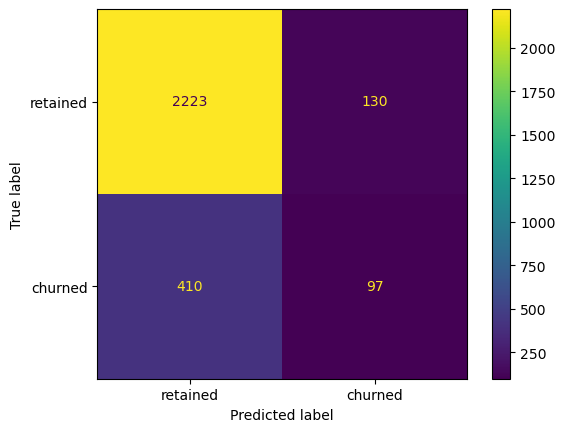

In [36]:
# Generate array of values for confusion matrix
cm = confusion_matrix(y_test, xgb_test_preds, labels=xgb_cv.classes_)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=['retained', 'churned'])
disp.plot();

> The model predicted three times as many false negatives than it did false positives, and it correctly identified only 19.13% of the users who actually churned.

### **Task 14. Feature importance: inspect the most important features of the final model**

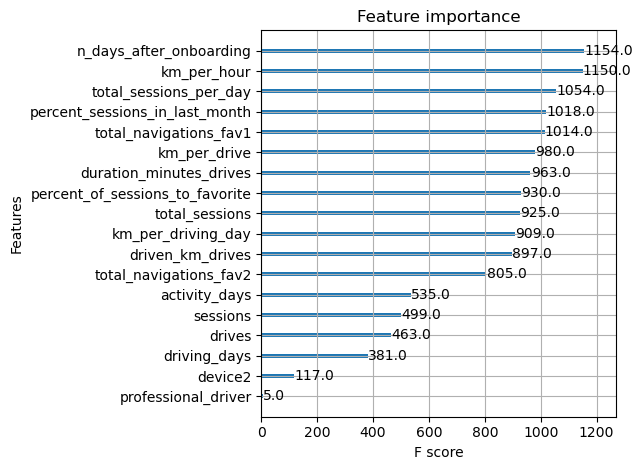

In [49]:
ax = plot_importance(xgb_cv.best_estimator_)
ax.figure.tight_layout()
ax.figure.savefig('feature_importance.png')

> The XGBBoost model used many more of the features than did the binomial logistic regression model, which weighted a single feature (`activity_days`) very heavily in its final prediction.

> The engineered features accounted for six of the top 10 features (and three of the top five)

### **Task 15. Conclusion and Recommendations**

* Random Forest and XGBoost models were developed, and the results were cross-compared to select the model with the highest predictive power.

* Before modeling, the dataset was split into training, validation, and test sets. The tradeoff with splitting the data three ways is that there is less data to train the model. However, selecting the champion model using a separate validation set enables the testing of the model by itself on the test data. This gives a better estimate of the performance on new future data than splitting the data two ways and selecting a champion model by performance on the test data.

* Engineered features made up over half of the top 10 most predictive features used by the model:
    1. km_per_hour
    2. total_sessions_per_day
    3. percent_sessions_in_last_month
    4. km_per_drive
    5. percent_of_sessions_to_favorite
    6. km_per_driving_day
  
* The XGBoost model fits the data even better than the random forest model. During the model selection, XGBoost's recall score (17%) is nearly double the logistic regression model's recall score (9%), and it's over 30% better than the random forest model's recall score (13%) while maintaining a similar accuracy and precision score.

* Tree-based model ensembles are the better predictors in this project than a singular logistic regression model. Random Forest and XGBoost achieved higher scores across all evaluation metrics and required less preprocessing of the data. However, it is more difficult to understand how they make their predictions.

* The modeling effort confirms that the current data is inadequate to predict user churn consistently; there is a great need for additional data or features that strongly correlate with user churn. Drive-level information for each user (such as drive times, geographic locations, etc.) would probably be helpful. It would also be beneficial to have more granular data to know how users interact with the app (e.g., how often users report or confirm road hazard alerts?). Lastly, it could be useful to know the monthly count of unique starting and ending locations each driver inputs.

* In this modeling effort, it was proven that the engineered features improve the performance of the models. It is recommended that a second iteration of the User Churn Project be conducted using more unseen features, as mentioned above, and with different combinations of predictor variables to reduce noise from unpredictive features. 

## [Link to the Waze App User Churn Prediction Project | Machine Learning Model](https://docs.google.com/presentation/d/10wSPMdx_Tev-j-A5k_wkXXpAbUS_eFZXua8Gy4oek7M/edit?usp=sharing)